In [2]:
# allows to import own functions
from src.utils.help_func import results_searchcv
from src.features.add_features import features_graph, features_pop
import sys
import os
path_name = os.getcwd()
root_project = os.path.split(path_name)[0]
sys.path.append(root_project)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
from scipy.stats import uniform, expon, randint, loguniform
from matplotlib.ticker import PercentFormatter
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
import joblib
import json
sns.set()
%matplotlib inline

In [4]:
# pd.set_option('display.max_rows', 500)
# pd.reset_option('display.max_rows')

In [5]:
df_1 = pd.read_pickle('../data/processed/sim_closure_100k.pickle')
df_2 = pd.read_pickle('../data/processed/sim_closure_topk_10k.pickle')
df_3 = pd.read_pickle('../data/processed/sim_closure_errors_50k.pickle')
df = pd.concat([df_1.sample(2500), df_2.sample(2500), df_3.sample(5000)])
df.reset_index(inplace=True, drop=True)
df

,initial_country,idx_country,R0,Tc,Tr,omega,limit_deaths,n_closed,react_time,total_infected,total_death,total_recovered
0,TON,184,2.836616,2.820155,7.999699,0.074552,46,17,14,8.624700e+04,3.217500e+04,54000.0
1,BIH,23,5.130011,3.043518,15.613280,0.001930,987,7,3,3.307450e+06,9.665900e+04,3210663.0
2,COL,40,12.549703,0.720264,9.039098,0.404860,590,8,15,4.963816e+07,3.898520e+07,10652934.0
3,AZE,11,4.814107,2.249548,10.829564,0.000325,77,0,17,9.884540e+06,3.464500e+04,9849810.0
4,HKG,83,5.245004,2.193442,11.504613,0.009128,187,4,26,7.416230e+06,7.046960e+05,6711423.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,THA,181,4.373479,5.202191,22.751671,0.106797,935,8,22,5.093375e+07,3.608329e+07,14850106.0
9996,IND,86,9.604655,3.236881,31.089130,0.178738,579,19,10,1.266686e+09,1.073500e+09,193186400.0
9997,SAU,159,7.735175,3.317020,25.657735,0.108773,727,17,6,3.275597e+07,2.411517e+07,8640682.0
9998,USA,195,1.253656,12.070477,15.132223,0.050709,826,13,9,1.000000e+00,0.000000e+00,0.0


## AÑADO NUEVOS FEATURES

In [6]:
df = features_graph(df)
df = features_pop(df)

## MODELO

Parece que o bien se producen muchos infectados, o muy pocos, si pasa algo.. claro, depende de R0 el número de infectados! Si es bajo habrá pocos infectados.

In [7]:
# sns.pairplot(df)

In [8]:
# df_model = df.drop(['idx_country', 'total_infected', 'total_recovered'], axis=1)
# df_model = df[['R0', 'Tr', 'omega', 'limit_deaths', 'n_closed', 'react_time', 'total_death', 'betweenness', 'degree', 'closeness']]
df_model = df[['R0', 'Tr', 'omega', 'limit_deaths', 'n_closed', 'react_time', 'total_death', 'betweenness', 'degree', 'closeness',
               'country_pop']]
df_model

,R0,Tr,omega,limit_deaths,n_closed,react_time,total_death,betweenness,degree,closeness,country_pop
0,2.836616,7.999699,0.074552,46,17,14,3.217500e+04,0.000000,0.027027,0.332335,1.031970e+05
1,5.130011,15.613280,0.001930,987,7,3,9.665900e+04,0.000007,0.090090,0.403636,3.323929e+06
2,12.549703,9.039098,0.404860,590,8,15,3.898520e+07,0.001736,0.189189,0.464435,4.964868e+07
3,4.814107,10.829564,0.000325,77,0,17,3.464500e+04,0.000554,0.198198,0.449393,9.942334e+06
4,5.245004,11.504613,0.009128,187,4,26,7.046960e+05,0.015386,0.378378,0.531100,7.451000e+06
...,...,...,...,...,...,...,...,...,...,...,...
9995,4.373479,22.751671,0.106797,935,8,22,3.608329e+07,0.016814,0.495495,0.532374,6.942852e+07
9996,9.604655,31.089130,0.178738,579,19,10,1.073500e+09,0.017188,0.441441,0.537530,1.352617e+09
9997,7.735175,25.657735,0.108773,727,17,6,2.411517e+07,0.009627,0.387387,0.526066,3.369995e+07
9998,1.253656,15.132223,0.050709,826,13,9,0.000000e+00,0.184702,0.819820,0.620112,3.271674e+08


In [9]:
X = df_model.drop('total_death', axis=1)
y = df_model['total_death']

In [10]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(
    X, y, random_state=42)

In [11]:
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

param_dist = dict(
    n_estimators=randint(low=1, high=2000),
    max_features=['auto', 'sqrt'],
    max_depth=max_depth,
    min_samples_split=randint(low=2, high=11),
    min_samples_leaf=randint(low=1, high=5),
    bootstrap=[True, False]
)

In [12]:
param_dist

{'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f76f82df640>,
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f76f82df970>,
 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f76f82dfb50>,
 'bootstrap': [True, False]}

In [13]:
gridsearch = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), param_dist, random_state=42, n_iter=50, n_jobs=-1, verbose=2)

gridsearch.fit(X_train_validation, y_train_validation)

joblib.dump(gridsearch, '../models/gridsearch_randomf_closures_5k_rev3.pkl')

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 10.8min finished


['../models/gridsearch_randomf_closures_5k_rev3.pkl']

In [14]:
gridsearch = joblib.load('../models/gridsearch_randomf_closures_5k_rev3.pkl')

In [15]:
results_searchcv(gridsearch, X_test, y_test)

The best score is:
0.9152467677744702
The best parameters found are:
{'bootstrap': True, 'max_depth': 110, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1900}
The score in test is:
0.9285440888685444
The r2-square is
0.9285440888685444
The MAE is:
7207328.785594098


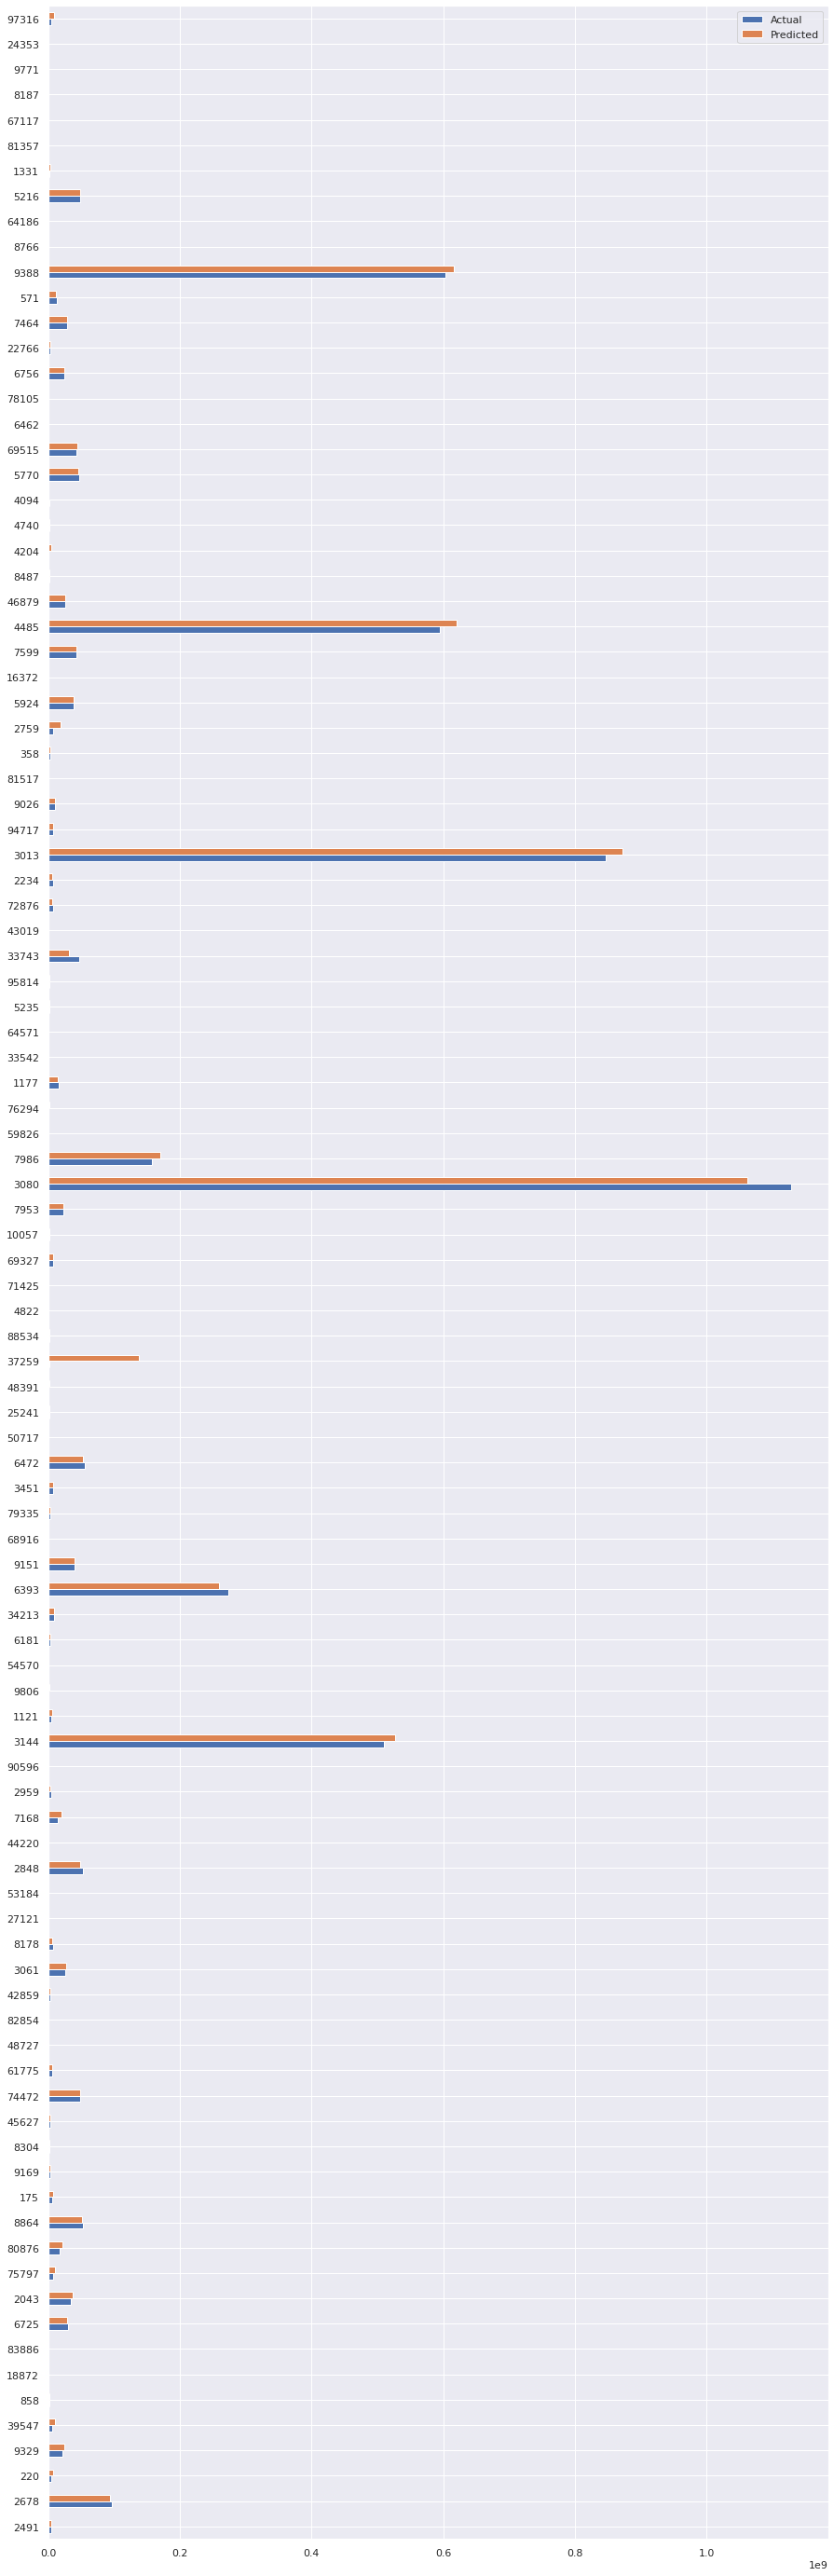

In [19]:
y_predicted = gridsearch.predict(X_test)
df_predicted = pd.DataFrame({'Actual': y_test, 'Predicted': y_predicted})
df_predicted.sample(100).plot(kind='barh', figsize=(15, 50))
plt.show()